# Введение в глубокое обучение

## Занятие 9. Компьютерное зрение. Сегментация и детекция.

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

План занятия:

1. Постановка задачи сегментации. Идеи решения задачи сегментации
2. Transposed convolution, SegNet
3. U-Net
4. Построение SegNet для решения задачи сегментации родинок и меланом
5. (Если успеем) Постановка задачи детекции. Идея устройства нейросети для решения задачи детекции

Мы с вами уже познакомились с тем, как устроены сверточные нейросети, которые применяются для задач, связанных с изображениями. Мы научились строить сверточные сети для задачи классификации картинок. Но кроме задачи классификации в компьютерном зрении существуют еще много разных типов задач. Сегодня мы рассмотрим две из них — ***детекцию*** и ***сегментацию***.

На картинке ниже показаны сути задач детекции, классификации и сегментации:

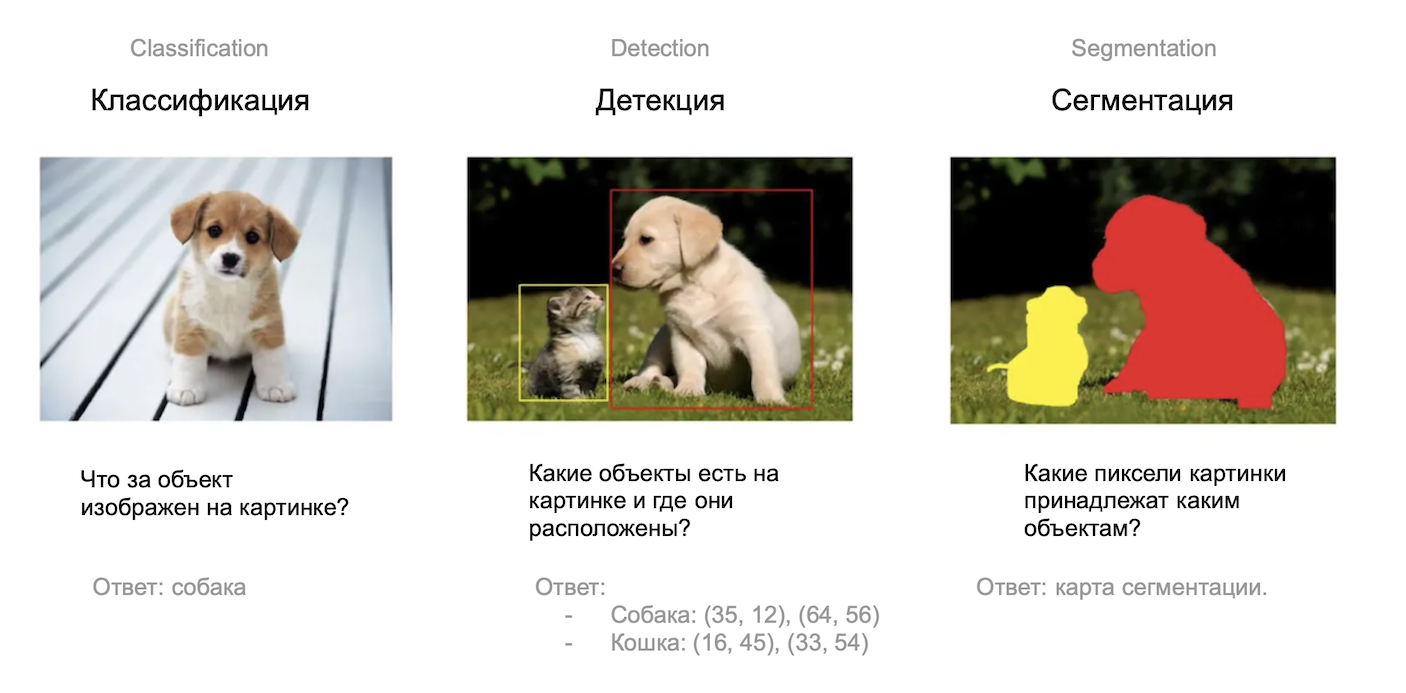

Задача сегментации тоже делится на несколько типов. Два самых распространенных типа — semantic segmentation (семантическая сегментация) и instance segmentation (инстанс-сегментация):
- в semantic segmentation нейросеть должна выделить пиксели объектов одного класса одним цветом;
- в instance segmentation нейросеть должна выделить пиксели разных объектов (даже если объекты одного класса) разными цветами;

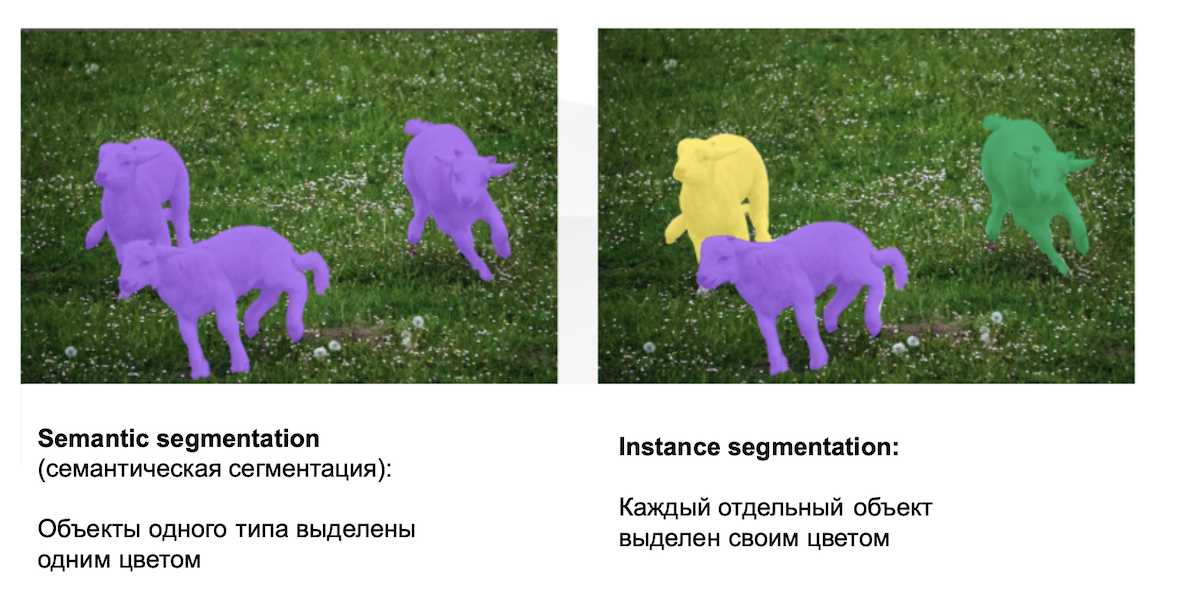

Мы будем рассматривать задачу семантической сегментации, так как она проще.

## Сегментация: Теория

### Семантическая сегментация

### Постановка задачи

Даны классы объектов, которые мы хотим сегментировать. Например, пусть мы хотим научиться сегментировать пять видов объектов:
1. человек;
2. сумка;
3. растительность;
4. дорога;
5. здания.

Вход нейросети — RGB картинка размера h*w*3 (так же, как в задаче классификации). Выход нейросети — двумерная карта сегментации размера h*w. Значение каждого пикселя карты сегментации — номер класса, которому принадлежит соответствующий пиксель исходной картинки.

На картинке могут быть объекты других классов, кроме тех, которые мы хотим сегментировать. Чтобы это учесть, добавим шестой класс сегментации: "фон". Ему будут соответствовать пиксели картинки, не принадлежащие ни одному из пяти заданных классов. В итоге наша задача превратится в задачу сегментации на 6 классов.



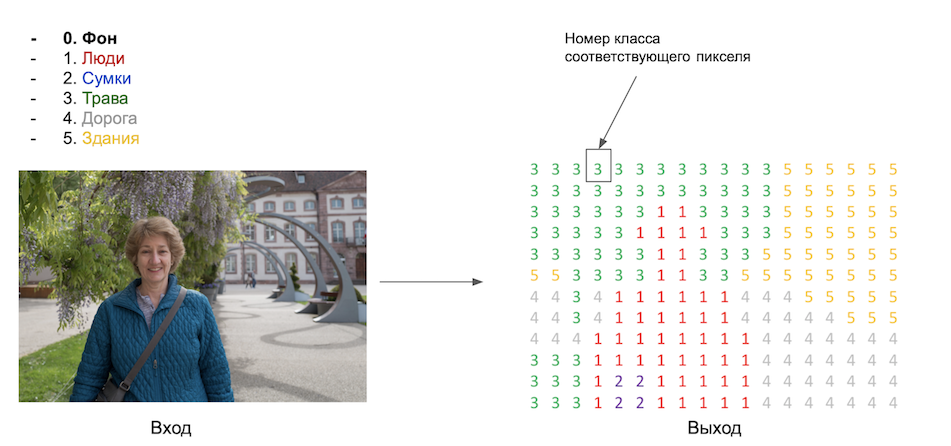

По сути, задача семантической сегментации — это задача классификации всех  пикселей картинки.

Вспомним, как решается задача классификации картинок: нейросеть для классификации в качестве ответа выдает не одно число — класс входящего объекта, — а вектор вероятностей принадлежности объекта к каждому из классов:

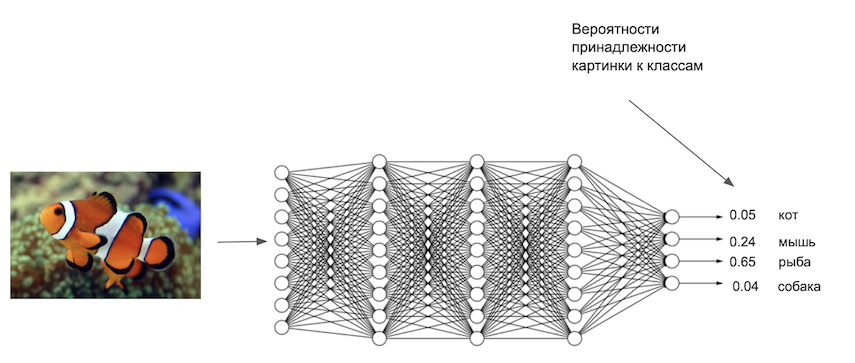

Поэтому логично было бы, чтобы нейросеть для сегментации для каждого пикселя выдавала тоже не одно число — класс этого пикселя, — а вектор вероятностей принадлежностей этого пикселя к каждому из заданных классов:

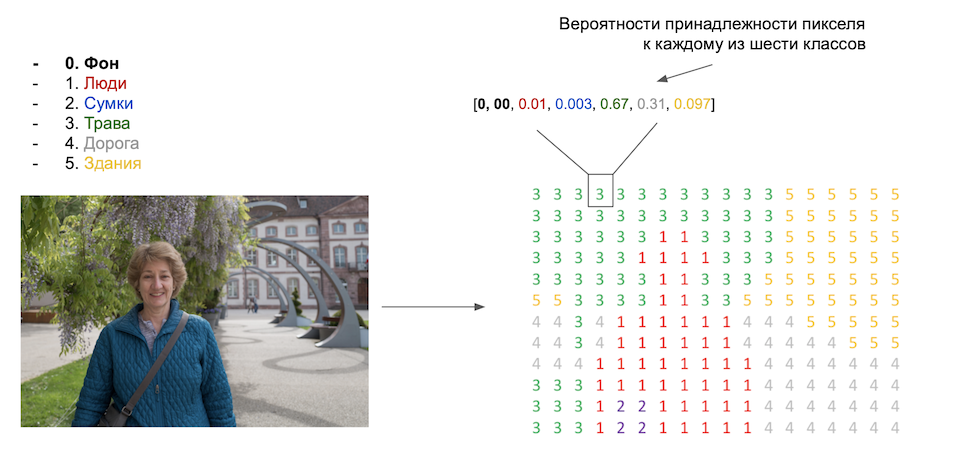

То есть, теперь желаемый выход нашей нейросети — это трехмерный тензор (матрица) размера h*w*c, где h, w — высота и ширина исходной картинки, c — количество классов сегментации (включая фон).

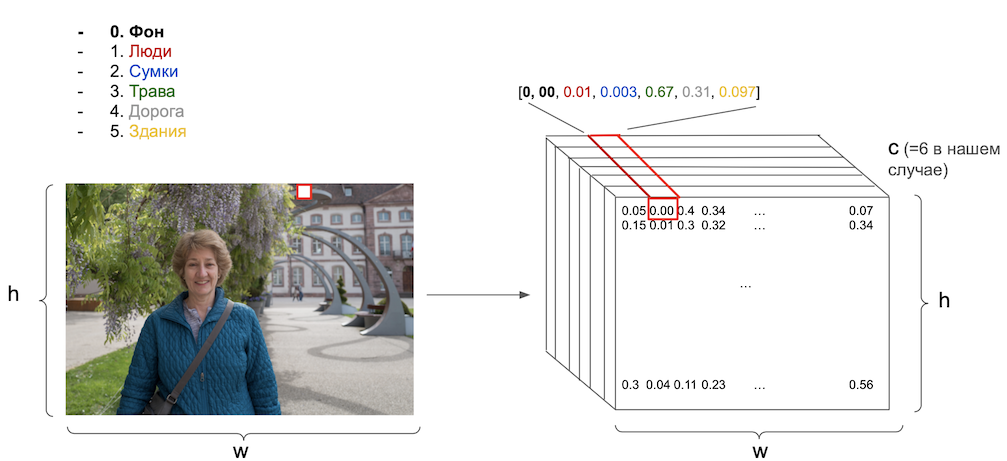

Итак, мы справились с постановкой задачи семантической сегментации. Поняли, что нйеросеть будет принимать на вход и что выдавать на выход. Теперь давайте поговорим об идеях того, как может быть устроена нейросеть для решения задачи семантической сегментации.

### Идеи решения задачи сегментации

#### №1: скользящее окно

Первая идея такая: смотрите, мы только что поняли, что сегментация — это, по сути, классификация каждого пикселя изображения. Так давайте и будем просто каждый пиксель классифицировать!

Пусть у нас есть картинка, которую мы хотим сегментировать. Будем проходиться по ней скользящим окном небольшого размера (например, семь на семь). В каждом положении скользящего окна будем подавать кусок картинки размера семь на семь, которую закрывает окно, на вход нейросети для классификации. Эта нейросеть будет одна и та же для всех положений скользящего окна. Задача этой нейросети — классифицировать центральный пиксель этого куска картинки на шесть классов. Понять, какому объекту из тех, что мы хотим сегментировать, этот пиксель принадлежит.

Например, на примере на слайде центральные пиксели первых двух патчей соответствуют траве, а  центральный пиксель третьего патча — человеку.

Таким образом, пройдясь скользящим окном по всей картинке, мы получим ответы нейросети для каждого пикселя картинки, чем, по сути, решим задачу сегментации этой картинки. Чтобы получать ответы также и для граничных пикселей картинки, можно добавить к изображению padding.


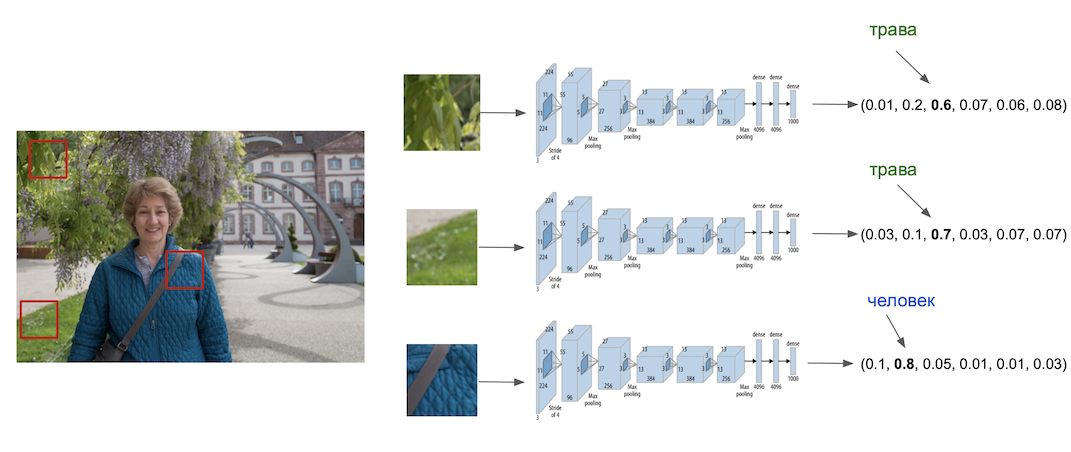

**Идея простая, но у нее есть довольно серьезные недостатки. **

Первый, самый очевидный — каждый патч картинки часто содержит очень малую часть объекта, по которой сложно, а иногда и практически невозможно понять, что на этом патче изображено. Посмотрим, например, на нижний патч на картинке выше. Согласитесь, даже для человека совсем не понятно, что это — часть куртки человека. Нейросеть на таких патчах тоже, конечно же, будет ошибаться.

Короче говоря, часто объекты имеют довольно большой размер, и чтобы эффективно классифицировать все пиксели этих объектов, скользящее окно должно быть довольно больших размеров. Настолько большим, чтобы, в идеале, захватывать весь объект целиком. Но в этом случае усугубляется вторая проблема такого алгоритма: он становится очень долгим.

Чтобы сегментировать одну картинку размера 32х32, нам нужно тысячу раз прогнать патч через сеть для классификации. Тысяча вызовов алгоритма — это довольно много, и работать это будет долго. А представьте, если у нас картинки больших размеров? А если при этом сделать размер патча больше, то сеть для классификации начнет работать еще дольше, и одна сегментация одной картинки станет занимать огромное количество времени и вычислительных ресурсов.

Выходит, подобный алгоритм неэффективен как с точки зрения качества сегментации, так и с точки зрения времени работы.


#### №2: fully-convolutional network

Идея такая: давайте сделаем сверточную нейросеть, у которой все карты активации будут иметь размер исходной картинки. И в последнем сверточном слое будет C карт активаций, где С — количество классов сегментации в нашей задаче. Полносвязных слоев у такой сети не будет. Такие сети, которые состоят только из сверточных слоев, называются fully-convolutional network.

Будем обучать эту нейросеть так, чтобы последние карты активации содержали ответ задачи сегментации на входящую картинку. Итоговая двумерная карта сегментации получается тем, что мы берем аргмаксимум по третьей размерности выхода сети.


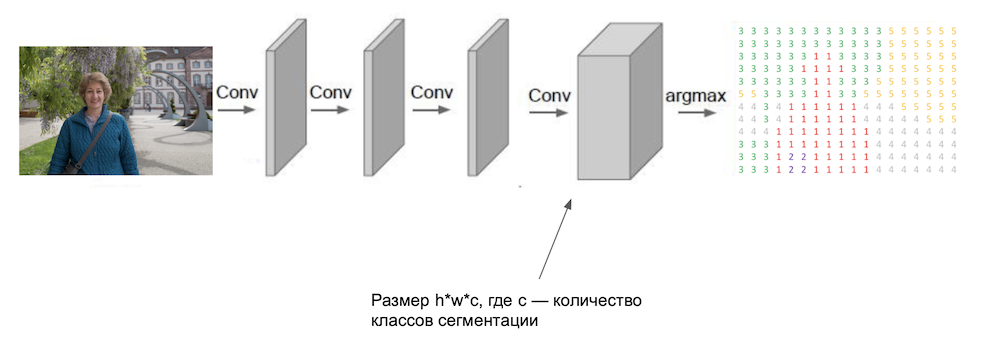

Эта идея будет работать, но и у нее есть существенный недостаток. Он снова связан с тем, что такая нейросеть будет работать очень долго. Если картинка, которую вы подаете на вход модели, большого размера, то и все карты активации на всех этапах работы сети будут такого же большого размера. А для вычисления таких больших карт активации требуется много вычислительных ресурсов.

Значит, **мы хотим как-то сократить количество вычислений, которые нейросеть делает в процессе сегментации. **


#### №3: convolutional network + upsampling

Третья идея такая: чтобы уменьшить количество вычислений, давайте все же будем уменьшать размеры карт активаций при движении к концу сети. Выход нейросети будет размера h’ x w’ x c, где h’ и w’ — размеры карт активацийпоследнего слоя, c — количество классов сегментации. По сути, нейросеть будет выдавать уменьшенную версию карты сегментации. Ну или карту сегментации для уменьшенной изначальной картинки.

После этого мы эту карту сегментации будем увеличивать до оригинального размера картинки. Увеличивать будем простым алгоритмом upsampling, по сути, просто растягивая полученную картинку по длине и ширине.



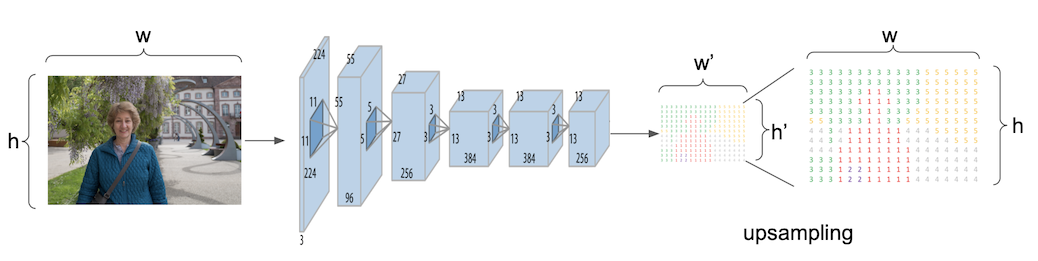

Пример upsampling (этот вариант называется nearest neighbors):

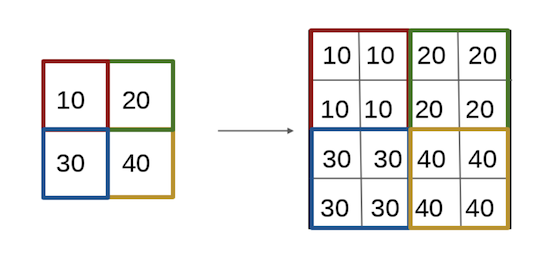

У этого алгоритма есть очевидный недостаток: точность его работы. Алгоритм предсказывает карту сегментации для уменьшенной версии исходной картинки, и от этого теряются детали, и сегментация получается очень неточной.

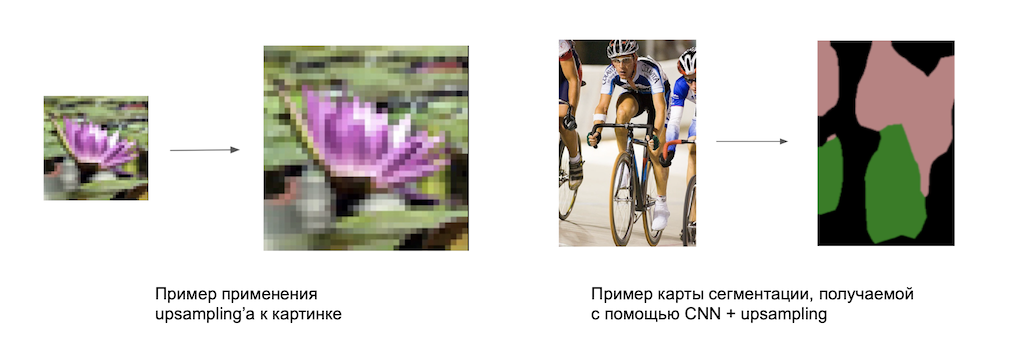



Однако этот алгоритм довольно долго использовался для решения задачи сегментации. И люди за время придумали, как улучшить точность итоговой карты сегментации с помощью специального алгоритма для постобработки результата. Он называется conditional random fields, сокращенно CRF. И он улучшал качество сегментации довольно сильно.

Вот пример того, какой могла получиться карта сегментации на выходе нейросети и после применения CRF:



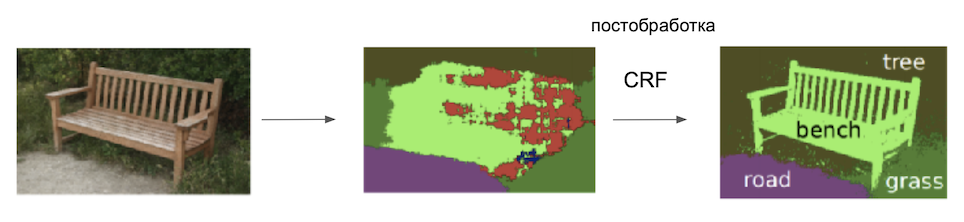

Итак, мы рассмотрели три идеи устройства архитектуры сети для решения задачи сегментации. У всех них есть существенные недостатки.

Давайте обратим внимание на две последние идеи (fully-convolutional network и CNN + upsampling). В идеале нам бы хотелось получить что-то среднее между ними: нейросеть, которая была бы способна выдавать хорошую карту сегментации того же размера, что изначальная картинка, но при этом у нее не было бы такое большое количество параметров, как у fully-convolutional network.

По сути, **мы хотели бы придумать более умную замену upsampling'у**. И сейчас мы поймем, как это сделать. Для этого изучим новый слой: transposed convolution.

### Transposed convolution

**Transposed convolution — обучаемая замена алгоритму upsampling**. Transposed convolution — слой, который увеличивает размеры карт активаций (а не уменьшает их размер, как обычный сверточный слой). Как понятно из названия, слой transposed convolution основан на свертках.

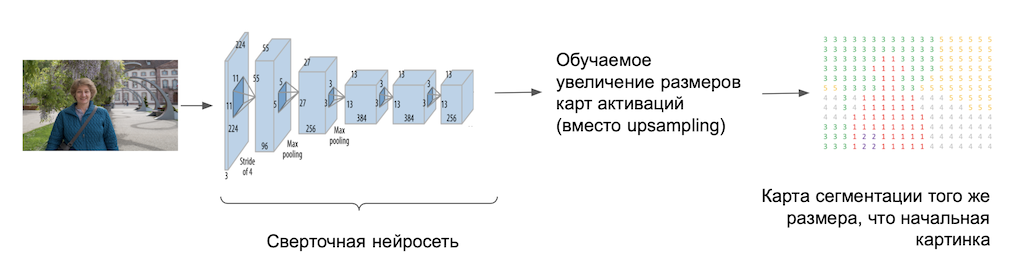

**Transposed convolution — это комбинация upsampling + convolution**



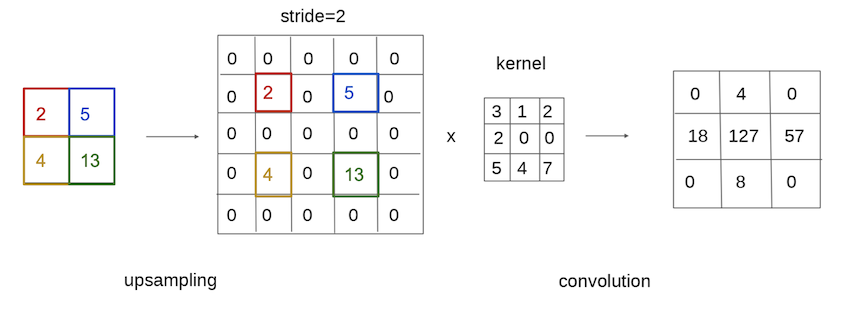

Бывают разные варианты upsampling, но для transposed convolution чаще всего используют bed of nails:

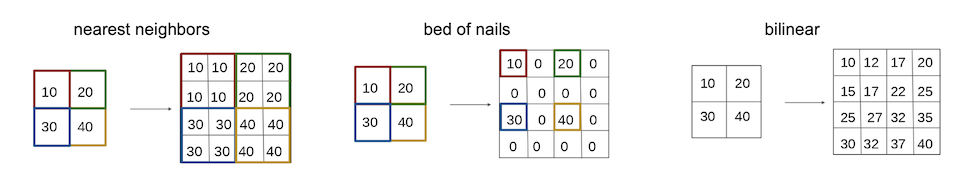

Применяя к изначальной карте активации разные виды upsampling'а с разными параметрами, можно получать разные виды слоев transposed convolution.

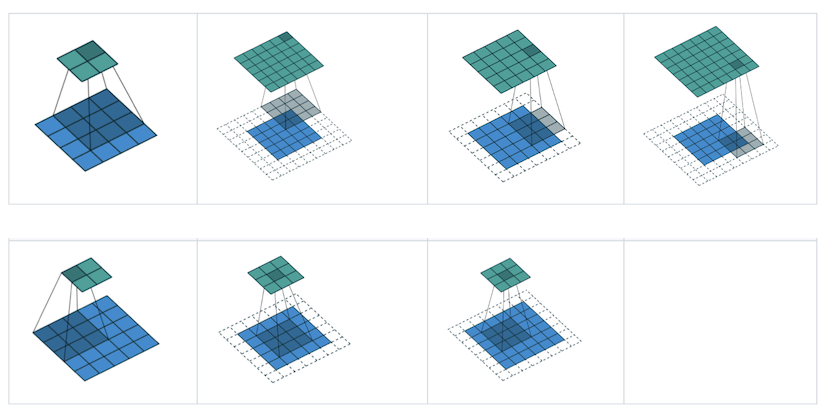

(Анимированный вариант картинок выше [можно найти тут](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))

Обучаемыми параметрами слоя transposed convolution являются все веса всех фильтров. Upsampling не является обучаемым.

Слой transposed convolution также часто называют deconvolution. Строго это неправильно: операция transposed convolution не является обратной к операции convolution. Но в литературе часто можно встретить название deconvolution применительно к transposed convolution.

### SegNet

Таким образом, вместо простого upsampling в нейросети мы можем использовать слои transposed convolution (т.е. слои upsampling+conv). В итоге схему нейросети можно проиллюстрировать так:

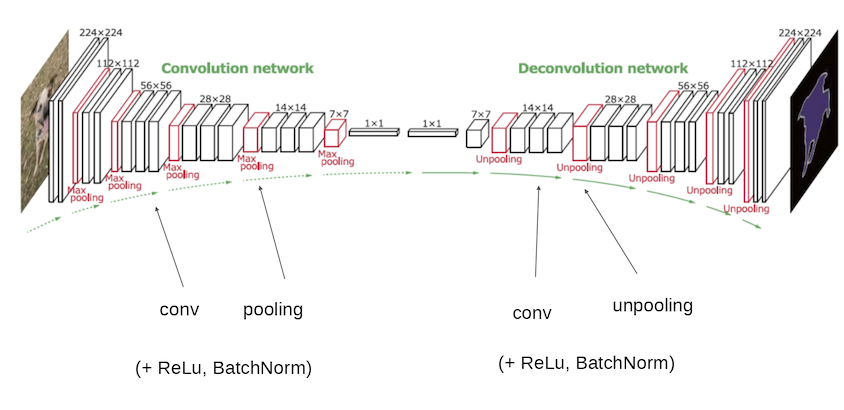

У такой нейросети можно условно выделить две части: encoder (левая часть, свертки) и decoder (правая часть, transposed convolution). Чаще всего encoder и decoder делают симметричными: каждый слой upsampling в декодере соответствует слою pooling в енкодере, а каждый слой conv в декодере — слою conv в енкодере.

Такая архитектура нейросети — классическая для решения задачи сегментации. Она называется SegNet.

### U-Net

U-Net — это нейросеть на основе SegNet со skip connection.

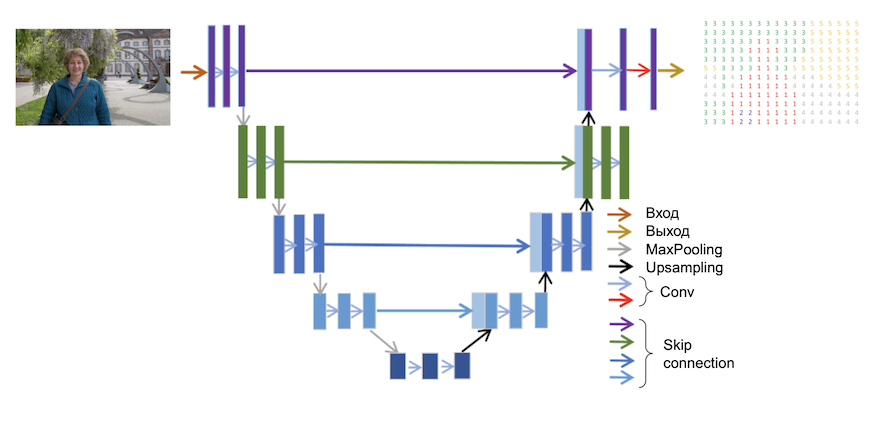

Skip connection проводится из выхода каждого блока левой части на вход соответствующему ему блоку правой части сети. Получается, блок правой части принимает на вход сумму карт активаций, пришедних из предыдушего слоя и из симметричного блока левой части сети.

Такая идея помогает нейросети создавать лучшие, более четкие карты сегментации. Смотрите, в нашей сети в середине есть узкое место: там, где карты активации сужаются и становятся малого размера. Такое место обычно называется bottleneck, то есть, бутылочное горлышко. И информация из изначальной картинки, когда она течет по сети, проходит через это узкое место, и часть информации там может теряться. Например, скорее всего, будет потеряна информация о мелких деталях исходного изображения. И когда затем слои транспонированной свертки правой части сети обратно восстанавливают изображение исходного размера, им может не хватать информации, полученной из последних слоев левой части, чтобы четко и качественно построить карту сегментации. Мелкие объекты, например, будут сегментированы плохо.

Применение такого skip connection помогает слоям правой части сети получить дополнительную информацию о том, как устроено исходное изображение. Это помогает получить более точную карту сегментации.

Такая нейросеть для сегментации со skip connection называется U-Net. U — потому что в такой иллюстрации сеть похожа на английскую букву U.


**Итак, мы поговорили о задаче сегментации**. Сформулировали постановку задачи, разобрали несколько идей ее решения. Познакомились с новым слоем: transposed convolution, и поняли, как с его помощью построить более эффективную архитектуру сети для задачи сегментации. И, кроме этого, поняли, что skip connection может быть полезен и в задаче сегментации.

Пора переходить к практике!

## Сегментация: Практика

### Скачивание и распаковка данных

Мы будем решать задачу бинарной сегментации родинок и меланом. Данные [можно скачать тут](https://disk.yandex.com/d/3hvHKFeex6j42Q). Также ниже есть ячейка, которая автоматически скачивает данные.

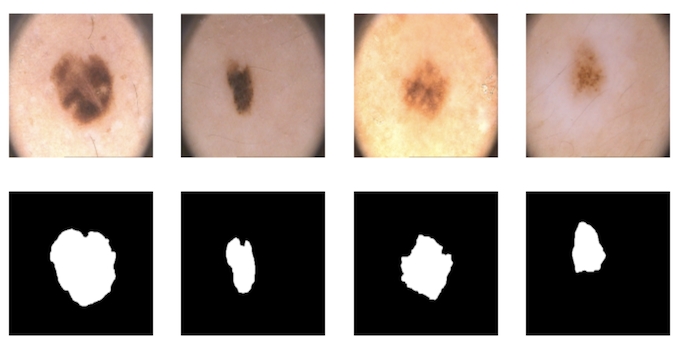

Скачиваем и распаковываем данные:

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/3hvHKFeex6j42Q) -o PH2.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  203M  100  203M    0     0  7314k      0  0:00:28  0:00:28 --:--:-- 7860k


In [ ]:
! unzip -qq PH2.zip

Стуктура датасета выглядит так:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

### Загрузка данных и построение датасета

Импортируем нужные модули:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

Чтобы обучить нейросеть на этих данных, нам нужно их загрузить самостоятельно.Давайте это сделаем:

In [ ]:
# библиотека для удобной работы с файлами на диске
import os
# библиотека для считывания картинок
from PIL import Image

# в эти массивы будем сохранять RGB картинки
# и их соответствующие карты сегментации
images = []
lesions = []

# название папки, в которой лежат данные
root = 'PH2 Dataset images'

# проходимся по всем подпапкам и файлам внутри директории root
for dirname, _, files in os.walk(root):
    # если название папки заканчивается на _Dermoscopic_Image,
    # то в ней лежит RGB картинка
    if root.endswith('_Dermoscopic_Image'):
        images.append(Image.open(os.path.join(dirname, files[0])))
    # если название папки заканчивается на _lesion,
    # то в ней лежит карта сегментации
    if root.endswith('_lesion'):
        lesions.append(Image.open(os.path.join(dirname, files[0])))

Отрисуем несколько картинок и их карт сегментации, чтобы понять, с чем мы имеем дело:

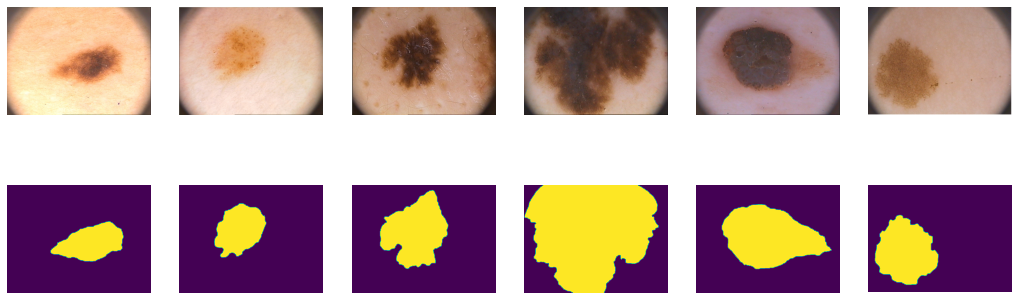

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.array(images[i]))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.array(lesions[i]))
plt.show();

Чтобы работать с данными для сегментации, нужно создать кастомный класс датасет.

In [ ]:
class PH2(Dataset):
    def __init__(self, images, lesions):

        self.images = images
        self.lesions = lesions

        self.img_transforms = transforms.Compose([
            transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
        ])

        self.seg_transforms = transforms.Compose([
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования.
        '''

        # находим по индексу нужные картинку и ее карту сегментации
        img = self.images[index]
        mask = self.lesions[index]

        # # применяем предобработку к RGB картинке
        img = self.img_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.seg_transforms(mask)

        # возвращаем пару: картинка — ее маска сегментации
        return (img, mask)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

In [ ]:
data = PH2(images, lesions)

Разделим наш датасет на три части: train, val и test:

In [ ]:
train_size = 100
val_size = 50
test_size = 50

train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

Обернем три части датасета в dataloader'ы:

In [ ]:
batch_size = 16
train_loader = DataLoader(train_data,
                     batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data,
                      batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data,
                     batch_size=batch_size, shuffle=False)

### Архитектура сети SegNet

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder. conv + pooling
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3), padding=1) # 256x256
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2)) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3), padding=1) # 128x128
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=(3,3), padding=1) # 64x64
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3,3), padding=1) # 32x32
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2)) # 32 -> 16

        # bottleneck (середина, самая узнкая часть сети)
        self.bottleneck_conv = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3,3), padding=1) # 16x16

        # decoder. upsample + conv
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=15, out_channels=12, kernel_size=(3,3), padding=1) # 32x32
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=12, out_channels=9, kernel_size=(3,3), padding=1) # 64x64
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=9, out_channels=6, kernel_size=(3,3), padding=1) # 128x128
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=(3,3), padding=1) # 256x256

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        # сигмоидная функция активации, потому что у нас задача
        # бинарной сегментации
        # в случае многоклассовой сегментации был бы softmax
        d3 = F.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

### Обучение сети

In [ ]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

Функция обучения сети:

In [ ]:
from IPython.display import clear_output

def train(model, opt, loss_fn, epochs, train_loader, val_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode

        avg_train_loss = 0
        for i, (X_batch, Y_batch) in enumerate(train_loader):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)

            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            avg_train_loss += loss / len(train_loader)

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)

        # 2. Тестируем сеть на картинках из val_loader
        model.eval()

        avg_val_loss = 0
        for i, (X_batch, Y_batch) in enumerate(val_loader):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)
            # считаем лосс на батче
            loss = loss_fn(Y_pred, Y_batch)

            avg_val_loss += loss / len(val_loader)

        # выводим средний лосс на валидационных данных
        print('avg val loss: %f' % avg_val_loss)


        # 3. Визуализируем ответы сети на шести картинках из валидационных данных

        # получаем один батч из data_val
        X_val, Y_val = next(iter(val_loader))
        # получаем ответ сети на картинки из батча
        Y_pred = model(X_val.to(device))
        Y_pred = Y_pred.detach().cpu().numpy()

        # удаляем предыдущую визуализацию
        clear_output(wait=True)

        # визуализируем исходные картинки, верный ответ и ответ нашей модели
        _, axes = plt.subplots(3, 6, figsize=(6*4, 3*4))
        for k in range(6):
            # отрисовываем 6 картинок, поданных на вход сети
            # картинки нормализованы, поэтому могут выглядеть непривычно
            axes[0][k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray', aspect='auto')
            axes[0][k].title.set_text('Input')

            # отрисовываем правильные маски сегментации для шести картинок выше
            axes[1][k].imshow(Y_val[k].numpy()[0], cmap='gray', aspect='auto')
            axes[1][k].title.set_text('Real Map')

            # отрисовываем ответы сети для каждого из четырех классов сегментации в отдельности
            axes[2][k].imshow(Y_pred[k][0], cmap='gray', aspect='auto')
            axes[2][k].title.set_text('Output')
        plt.suptitle('%d / %d - val loss: %f' % (epoch+1, epochs, avg_val_loss))
        plt.show()

Определяем модель, функцию потерь, оптимизатор, и запускаем обучение сети:

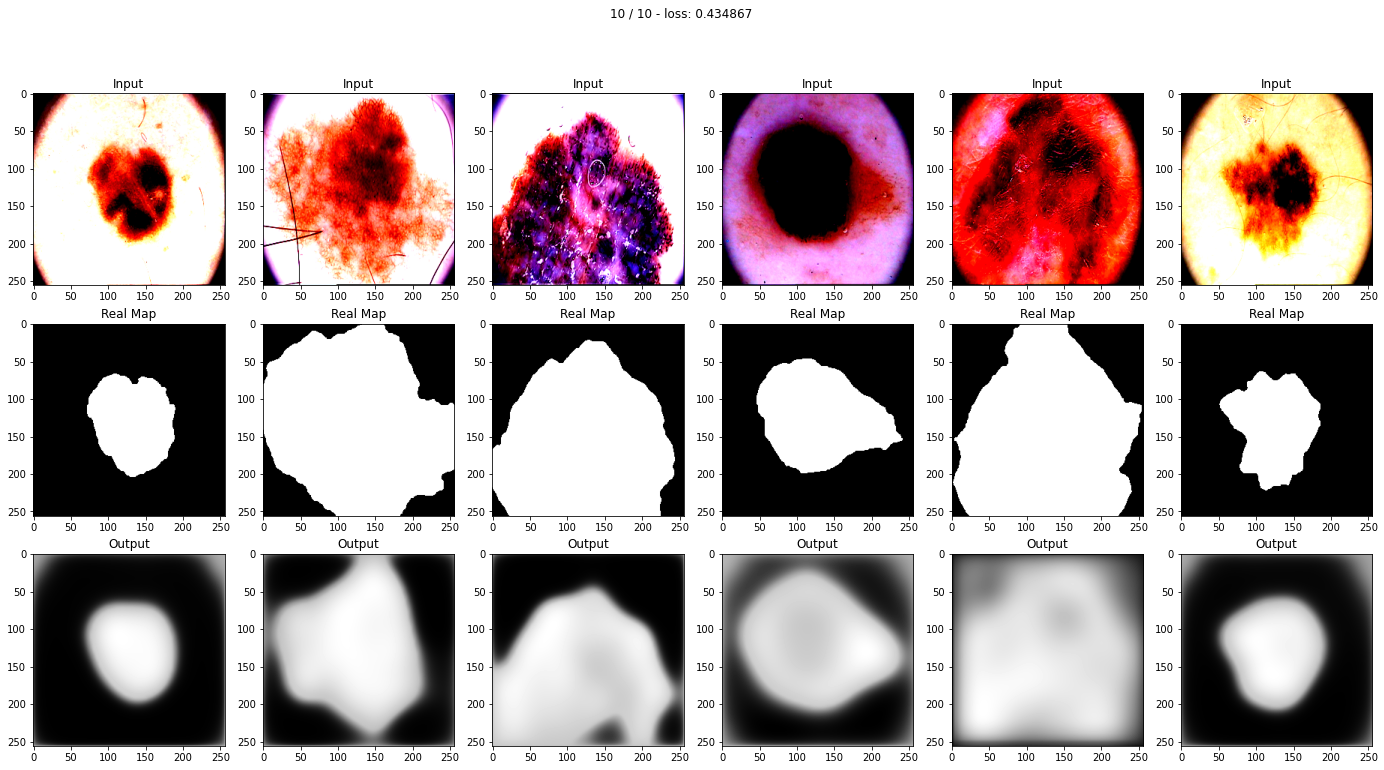

In [ ]:
model = SegNet().to(device)
# бинарная кросс-энтропия
loss = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, loss, 10, train_loader, val_loader)

### Метрика качества IoU

IoU — одна из стандартных метрик качества, которые используются в задаче сегментации.

Формула подсчета метрики:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Здесь:
- Пересечение (A ∩ B) — количество пикселей, которые помечены как пиксели объекта (т.е. имеют значение 1 в маске сегментации) *как* в маске предсказания модели, *так и *в правильной маске сегментации;
- Объединение (A ∪ B) — количество пикселей, которые помечены как пиксели объекта (т.е. имеют значение 1 в маске сегментации) *либо* в маске предсказания модели, *либо* в правильной маске сегментации;

И значение метрики IoU — это количество пикселей пересечения, деленное на количество пикселей объединения. Чем это значение больше, тем качество сегментации моделью лучше.

Пример: пусть правильная маска и ответ модели такие:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объекдинение выглядят так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

В PyTorch метрику IoU можно посчитать с помощью [torchmetrics.JaccardIndex](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html)

In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.1 MB/s 


In [ ]:
from torchmetrics import JaccardIndex

X_val, Y_val = next(iter(val_loader))
# получаем ответ сети на картинки из батча
Y_pred = model(X_val.to(device))

jaccard = JaccardIndex(task='binary').to(device)
jaccard(Y_pred, Y_val)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.6314)

In [ ]:
def evaluate(model, dataloader, loss_fn, metric_fn):

    losses = []
    metrics = []

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            # получаем выход модели
            logits = model(X_batch)

            # считаем лосс по батчу
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())

            # считаем метрику по батчу
            metric = metric_fn(logits, y_batch)
            metrics.append(metric.item())

    # возвращает средние значения лосса и метрики
    return np.mean(losses), np.mean(metrics)

Посчитаем средние лосс и метрику на train, val и test частях датасета:

In [ ]:
evaluate(model, train_loader, loss, jaccard)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.39983321513448444, 0.6025677)

In [ ]:
evaluate(model, val_loader, loss, jaccard)

(0.43486687541007996, 0.60284144)

In [ ]:
evaluate(model, test_loader, loss, jaccard)

(0.3820820339024067, 0.5441674)

## Детекция

### Постановка задачи

Даны классы объектов, которые мы хотим детектировать:
- кошка;
- собака;
- человек;
- ...

На вход нейросети подается RGB картинка (так же, как и в задаче классификации). На выходе нейросеть выдает набор пар (класс, координаты bounding box).
- (собака, [35, 12], [64, 56]);
- (кошка, [16, 45], [33, 54]);
- ...

Координата каждого bounding box — это пара [x1, y1], [x2, y2], где [x1, y1] — координаты левого верхнего угла bounding box'а, [x2, y2] — координаты правого нижнего угла bounding box'а.

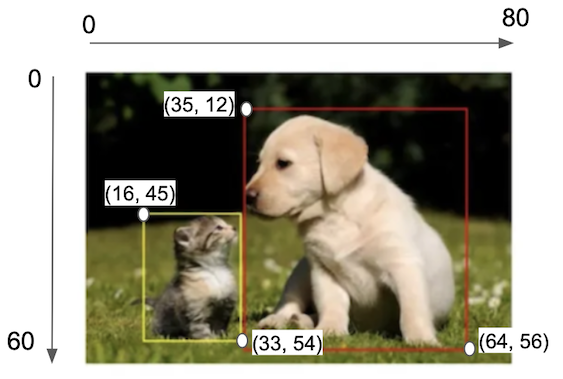

Иногда координаты bounding box'ов кодируют по-другому: парой [x1, y1], [w, h], где [x1, y1] — координаты левого верхнего угла bounding box'а, [w, h] — ширина и длина bounding box'а:

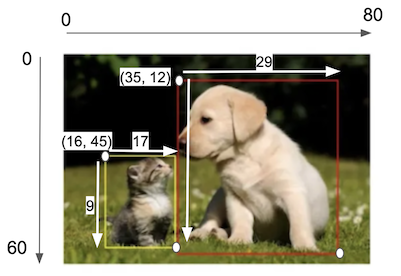

### Идеи устройства моделей для решения задачи детекции

#### R-CNN

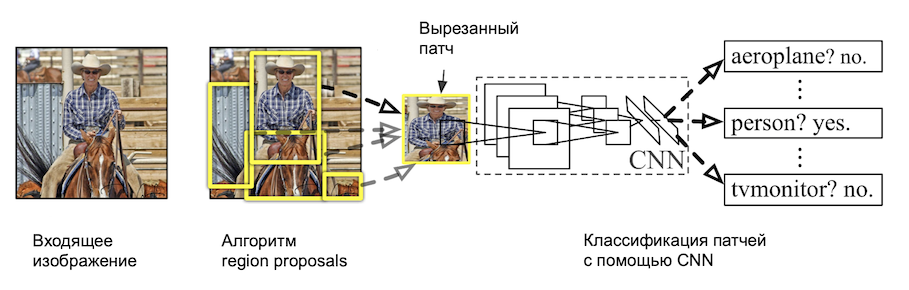

Идея устройства R-CNN такая:
1. На входящей картинке запустить алгоритм region proposals. Этот алгоритм выдает примерные положения bounding box'ов, где могли бы располагаться объекты. Алгоритм выдает примерно 2 тысячи претендентов на bounding box'ы;
2. Все части картинки внутри bounding box'ов, полученных на первом шаге, поадются на вход CNN для классификации.
4. Те bounding box'ы, в которых на втором шаге нашлись объекты, немного улучшаются с помощью эвристик.

**Region proposal algorithm**



На заре развития алгоритма R-CNN в качестве алгоритма region proposal предлагалось брать алгоритм сегментации (не основанный на нейросетях). Этот алгоритм выдавал иерархическую структуру сегментации картинки. Region proposals формировались с каждого уровня иерархии как box'ы, содержащие сегментированные объекты. Проиллюстрировать это можно примерно так:

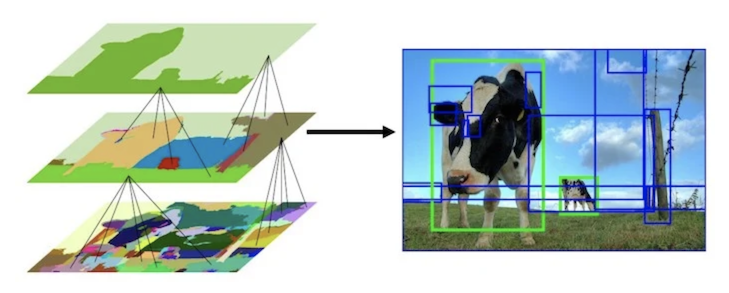

Этот алгоритм работал неплохо, но время его работы было довольно долгим. Поэтому на его основе были приудманы два улучшения: Fast R-CNN и Faster R-CNN. Подробнее про них можно узнать из лекций по детекции Deep Learning School (ссылки в разделе "дополнительно")

#### YOLO

Несмотря на все улучшения, алгоритмы детекции на основе идеи R-CNN все равно оказались довольно долгими. Долгое время работы получается в основном за счет того, что нужно много раз запускать сеть для классификации (один раз для каждого предполагаемого bounding box'а). Для real-time детекции они явно не подходили. Поэтому была придумана другая идея нейросети для детекции: **YOLO ("You Only Look Once")**. Нейросети на основе YOLO используются для real-time детекции и по сей день.

Главная фишка YOLO — она требует только одного прогона нейросети для детекции всех объектов на картинке.

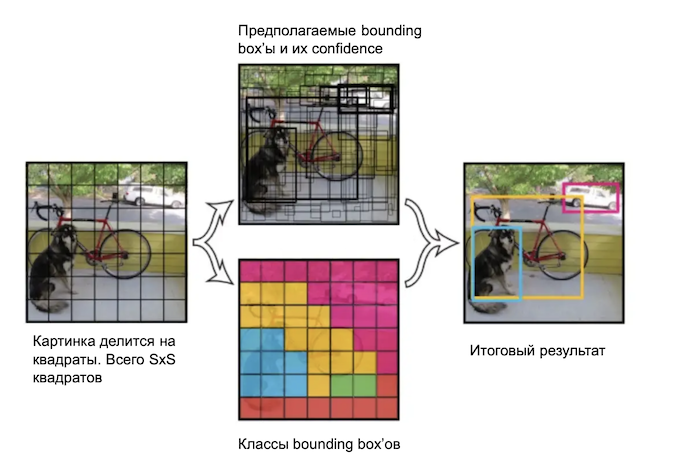

Идея работы YOLO:
1. Исходная картинка разбивается на пачти фиксированного размера. Всего SxS патчей;
2. Картинка подается на вход нейросети. Задача этой нейросети — для каждого из SxS патчей выдать b предполагаемых bounding box'ов. И для каждого bounding box'а выдать его координаты [x1, y1], [x2, y2] и confidence (уверенность) в том, что этот bounding box верный. Кроме этого, сеть для каждого патча должна выдать класс объекта, который находится в этом патче. Выходит, всего нейросеть выдает тензор размера SxSx(5b+c), где с — количество классов детекции.
3. Из всех SxSx5b bounding box'ов остаются только те, для которых confidence выше некоторого порога. Это и есть итоговый результат.

Этот алгоритм работает очень быстро, и пригоден для real-time детекции. По сей день исследователи продолжают придумывать идеи, как сделать YOLO еще быстрее.

Главный недостаток этого алгоритма — то, что он не может детектировать очень маленькие объекты. Для каждого патча в итоге остается только один bounding box. Если внутри одного патча помещались два или более объектов, детектирован может быть только один из них.

## Дополнительно

### Полезные ссылки

- Набор лекций по **детекции** в Deep Learning School:
    - [Повторение классификации](https://youtu.be/8D01Xo9hWgg);
    - [Основы детекции](https://youtu.be/Y4JvVOaZWsU);
    - [Двухстадийные нейросети](https://youtu.be/WrKl7GHWilA);
    - [Одностадийные нейросети](https://youtu.be/OPK63uqAQLs);
    - [Современные подходы и задачи](https://youtu.be/6WXUNNYysww).


- Набор лекций по **сегментации** в Deep Learning School:
    - [Введение](https://youtu.be/tIqndofykgc);
    - [Трюки и архитектуры нейросетей для сегментации](https://youtu.be/tIqndofykgc): transposed convolution, dilated convolution;
    - [U-Net](https://youtu.be/yEuIV5FsRMs).


- [Статья про устройство region proposals алгоритмов для детекции](https://learnopencv.com/selective-search-for-object-detection-cpp-python/) (на английском)
- [Статья про transposed convoliution](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)